# CNN for Sentence Classification 논문 구현

#### Git - Commit Message Convention

* 제가 대략적으로 framework을 잡아놓은 것이니, 담당하시는 부분에 수정이 필요하시면 마크다운 양식만 유지한 채 수정해주시면 됩니다!
* 작은 단위의 작업이 끝날 때 마다 git add, commit, push 해주시면 됩니다! (push하고 슬랙에 공유 부탁드려요! 화이팅!)

* git commit message는 다음의 양식을 참고해주세요!
    * 처음으로 코드 완료했을 때 git commit -m "동사 명사"
    ```ex) git commit -m "Fill and replace NaN values"```
    
    * commit 했던 코드를 수정했을 때 git commit -m "Update 수정한 내용"
    ```ex) git commit -m "Update Word embedding"```


# 1. 데이터 load 및 EDA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) 네이버 영화 리뷰 데이터 불러오기

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/CNN 공유폴더/ratings_train.txt", sep='\t')    #일단 제걸로 경로를 걸어놨습니다-옥영
test = pd.read_csv("/content/drive/MyDrive/CNN 공유폴더/ratings_test.txt", sep='\t')

In [ ]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
train.info()    #document에 null값 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
test.info()    #document에 null값 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
train[train['document'].isnull()]     #갯수가 별로 없고 대체할 방법이 없으므로 결측치 제거

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [ ]:
## 결측치 제거
train.dropna(inplace=True)
test.dropna(inplace=True)

## 2) Sentences, labels 생성

* sentence는 tokenize하고 나중에 생성 ☆
* label만 numpy 변경

In [ ]:
# import numpy as np

# train_labels = np.array(train.label)
# test_labels = np.array(test.label)

In [ ]:
len(test_labels)

49997

# 2. Data Preprocessing

### colab에서 konlpy, mecab 설치하기

In [ ]:
## mecab 설치

!pip3 install konlpy 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 67.7 MB/s 
Installing automake (A dependency for mecab-ko)
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages

## 1) Tokenizer

* 어절 단위
* 형태소 단위 - Mecab 활용
* Subword 단위

In [ ]:
# 영어, 한글만 포함하고 나머지 제거
import re

def preprocess(text):
  text = re.sub(r"[^A-Za-zㄱ-ㅎㅏ-ㅣ가-힣 ]","", text) 
  return text

train['document'] = train.document.apply(lambda x : preprocess(x))
test['document'] = test.document.apply(lambda x : preprocess(x))

train.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
# Mecab으로 형태소 분석, 불용어 제거
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']   #korean_stopwords 보류

train_tokens = []
test_tokens = []
train_drop_idx = []
test_drop_idx = []

for idx, sentence in enumerate(train['document']):
    tokenized_sentence = tokenizer.morphs(sentence) 
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    if len(stopwords_removed_sentence) != 0:
      train_tokens.append(stopwords_removed_sentence)
    else:
      train_drop_idx.append(idx)

for idx, sentence in enumerate(test['document']):
    tokenized_sentence = tokenizer.morphs(sentence) 
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    if len(stopwords_removed_sentence) != 0:
      test_tokens.append(stopwords_removed_sentence)
    else:
      test_drop_idx.append(idx)

In [ ]:
# ## Mecab 자소단위 - 보류

# train_tokens_jaso = []
# test_tokens_jaso = []
# train_drop_idx = []
# test_drop_idx = []

# for idx, sentence in enumerate(train['document']):
#     tokenized_sentence = tokenizer.morphs(sentence) 
#     stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
#     if len(stopwords_removed_sentence) != 0:
#       train_tokens.append(stopwords_removed_sentence)
#     else:
#       train_drop_idx.append(idx)

# for idx, sentence in enumerate(test['document']):
#     tokenized_sentence = tokenizer.morphs(sentence) 
#     stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
#     if len(stopwords_removed_sentence) != 0:
#       test_tokens.append(stopwords_removed_sentence)
#     else:
#       test_drop_idx.append(idx)


# def tokenize_by_morpheme_jaso(s):
#     return [to_jaso(token) for token in tokenize_by_morpheme_char(s)]

In [ ]:
train_tokens[:4]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다'],
 ['교도소', '이야기', '구먼', '솔직히', '재미', '없', '다', '평점', '조정']]

In [ ]:
test_tokens[:4]

[['굳', 'ㅋ'],
 ['GDNTOPCLASSINTHECLUB'],
 ['뭐', '야', '평점', '나쁘', '진', '않', '지만', '점', '짜리', '더더욱', '아니', '잖아'],
 ['지루', '하', '지', '않', '은데', '완전', '막장', '임', '돈', '주', '고', '보', '기']]

In [ ]:
## 길이 0인 리뷰 labels에서 제거

labels_train = train['label']
labels_test = test['label']

labels_train.drop(train_drop_idx, inplace=True)
labels_test.drop(test_drop_idx, inplace=True)

In [ ]:
len(labels_train), len(labels_test)

(149598, 49863)

In [ ]:
len(train_tokens), len(test_tokens)

(149598, 49863)

## 2) 리뷰 데이터 EDA

* 문장 histogram

In [ ]:
train_token_len = [len(tokens) for tokens in train_tokens]
test_token_len = [len(tokens) for tokens in test_tokens]

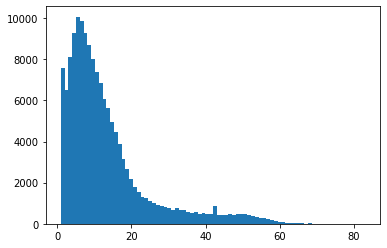

In [ ]:
plt.hist(train_token_len, bins=80)
plt.show()

In [ ]:
max(train_token_len), min(train_token_len)

(83, 1)

In [ ]:
sum(train_token_len)/len(train_token_len)

13.55445928421503

In [ ]:
type(train_token_len)

list

In [ ]:
# max_length 설정
import numpy as np

max_tokens = np.mean(train_token_len) + 1.5 * np.std(train_token_len)
max_length = int(max_tokens)

print('pad_sequences maxlen : ', max_length)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(train_token_len < max_tokens) / len(train_token_len) * 100))

pad_sequences maxlen :  30
전체 문장의 90.87621492265939%가 maxlen 설정값 이내에 포함됩니다. 


## 3) Word Vectorize

* word embedding : 문장들을 word vector 형태로 변환
    * 윗단에서 tokenizer output을 '문장' 형태라고 가정하고 코드 작업
    1. 문장을 토큰으로 쪼갠다
    2. 쪼개진 토큰을 가장 긴 문장에 맞춰 패딩한다
    3. 패딩이 마친 토큰들을 word vector로 변환하다
* oov, padding, truncating 확인

In [ ]:
# !python -m pip install tensorflow==2.3
# !python -m pip install --upgrade pip

In [ ]:
train_sentences = [" ".join(tokens) for tokens in train_tokens]
test_sentences = [" ".join(tokens) for tokens in test_tokens]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
## vocabulary, sequences 생성 및 padding 함수

def word_vectorize(sentences, max_length, oov_tok='<oov>',trunc_type='post'):

    tokenizer = Tokenizer(oov_token="<oov>")    #Tokenizer 객체 생성
    tokenizer.fit_on_texts(sentences)    #train sentences 입력
    word_index = tokenizer.word_index           #word : index 사전(vocab) 생성
    sequences = tokenizer.texts_to_sequences(sentences)     #시퀀스 생성
    padded = pad_sequences(sequences, maxlen=max_length, padding=trunc_type, truncating=trunc_type)   #padding, truncating

    return word_index, sequences, padded

In [ ]:
word_index, sequences, padded = word_vectorize(train_sentences, max_length)
word_index_test, sequences_test, padded_test = word_vectorize(test_sentences, max_length)

In [ ]:
len(vocabulary)

52170

In [ ]:
len(word_index), len(sequences)

(52170, 149598, 149598)

In [ ]:
len(word_index_test), len(sequences_test)

(31246, 49863, 49863)

In [ ]:
index_word = {value : key for (key, value) in word_index.items()}    #index : word 사전

## 시퀀스 decoding 함수
def decode_review(text):
  return " ".join([index_word.get(i, '?') for i in text])

In [ ]:
sequences[0]    # 첫 번째 시퀀스 확인

[26, 65, 912, 31, 214, 13, 27, 705]

In [ ]:
decode_review(padded[0])    # padded 된 시퀀스 -> decode해서 확인

'아 더 빙 진짜 짜증 나 네요 목소리 ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?'

## 4) FastText pre-trained model 불러오기

* pre-trained model : https://github.com/Kyubyong/wordvectors
    * korean fasttext file download 후 **ko.bin**(word vector + model) 파일 로드
    * gensim.models.fasttest의 load_facebook_model() 메소드는 로컬에서 돌아가지만, colab에서는 지원하지 않음
    * **colab에서는 gensim.models.fasttest.FastText의 load_fasttext_format() 메소드를 사용해야함!**

* (참고) facebook에서 제공하는 기본 pre-trained 모델 (성능이 별로 좋지 않다고 함) : https://fasttext.cc/docs/en/crawl-vectors.html

In [ ]:
## 1차시도 - 로컬 환경에서는 load_facebook_model() 함수를 사용가능!

# import datetime
# from gensim.models import fasttext

# print(f"Load fasttext START at {datetime.datetime.now()}")
# model = fasttext.load_facebook_model("./ko.bin")
# print(f"Load fasttext   END at {datetime.datetime.now()}")

In [ ]:
## 모델 가져오기

# import datetime
# from gensim.models.fasttext import FastText

# print(f"Load fasttext START at {datetime.datetime.now()}")
# model = FastText.load_fasttext_format("/content/drive/MyDrive/CNN 공유폴더/ko.bin")    #일단 제걸로 경로 걸어놨습니다-옥영
# print(f"Load fasttext   END at {datetime.datetime.now()}")

Load fasttext START at 2022-03-10 04:58:44.959026
Load fasttext   END at 2022-03-10 04:58:49.329630


In [ ]:
# print(model.wv.most_similar('선생님'))

[('엄마', 0.55759197473526), ('교실', 0.5458134412765503), ('학교의', 0.525463879108429), ('상냥', 0.5112130045890808), ('쿈', 0.5072376728057861), ('아빠', 0.5071090459823608), ('레슨', 0.5016893744468689), ('담임', 0.49494361877441406), ('교장', 0.488463819026947), ('부모님', 0.48817840218544006)]


In [ ]:
## 단어 벡터 가져오기

import datetime
from gensim.models.keyedvectors import KeyedVectors

print(f"Load fasttext START at {datetime.datetime.now()}")
fasttext = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/CNN 공유폴더/ko.vec")    #일단 제걸로 경로 걸어놨습니다-옥영
print(f"Load fasttext   END at {datetime.datetime.now()}")

Load fasttext START at 2022-03-11 03:19:17.217432
Load fasttext   END at 2022-03-11 03:19:20.699236


In [ ]:
## 확인

print(f"Type of model: {type(fasttext)}")
print(fasttext.most_similar('선생님'))
print(fasttext.similarity('학교', '학생'))

Type of model: <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
[('선생', 0.5959742069244385), ('친구', 0.5727324485778809), ('엄마', 0.5673927068710327), ('교실', 0.551629900932312), ('학년', 0.5418113470077515), ('학교의', 0.5392658710479736), ('깡', 0.5327038168907166), ('교장', 0.5243597030639648), ('여학생', 0.5235006809234619), ('교사', 0.5217379331588745)]
0.6089581


In [ ]:
## word vocabulary list 생성

vocabulary = list(word_index.keys())
vocab_size = len(vocabulary)     #52170
embedding_matrix = np.zeros((vocab_size, 200))
vocab_size, embedding_matrix.shape

(52170, (52170, 200))

In [ ]:
for i, word in enumerate(vocabulary): 
    if word in fasttext: 
        embedding_vector = fasttext[word] 
        embedding_matrix[i] = embedding_vector

embed_dim = len(embedding_matrix[1])
embed_dim

200

## 5) Valid, Test set 생성

* valid : test = 0.8 : 0.2

In [ ]:
from sklearn.model_selection import train_test_split

valid_padded, test_padded, valid_labels, test_labels = train_test_split(padded_test, labels_test, test_size=0.2, shuffle=True)

In [ ]:
import numpy as np

labels_train = np.array(labels_train)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

In [ ]:
len(valid_padded), len(test_padded)

(39890, 9973)

# 3. Convolutional Neural Networks Modeling

#### 모델 생성 참고코드

In [ ]:
## 하은 - 참고코드

# conv_blocks = []
# for size in filter_sizes:
#     conv = keras.layers.Conv1D(filters=num_filters, kernel_size=size, padding="valid",
#                          activation="relu", strides=1)(z)
#     conv = keras.layers.MaxPooling1D(pool_size=2)(conv)
#     conv = keras.layers.Flatten()(conv)
#     conv_blocks.append(conv)

# z = keras.layers.Concatenate()(conv_blocks)
# z = keras.layers.Dropout(dropout)(z)
# z = keras.layers.Dense(hidden_dims, activation="relu")(z)
# model_output = keras.layers.Dense(1, activation="sigmoid")(z)

# model = keras.Model(model_input, model_output)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
## 실습 버전 - 참고

# Convolution + Batch Normalization + Relu
# class ConvBNRelu(Model):
#   def __init__(self, filters, kernel_size=(3, 3), strides=(1, 1), padding='same'):
#     super(ConvBNRelu, self).__init__()
#     self.conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
#                         padding=padding, kernel_initializer='glorot_normal')

#     self.batchnorm = BatchNormalization()

#   def call(self, inputs, training=False):
#     layer = self.conv(inputs)
#     layer = self.batchnorm(layer)
#     layer = tf.nn.relu(layer)

#     return layer

# # Dense layer + Normalization + Relu
# class DenseBNRelu(Model):
#   def __init__(self, units):
#     # units는 output 개수
#     super(DenseBNRelu, self).__init__()
#     self.dense = Dense(units=units, kernel_initializer='glorot_normal')
#     self.batchnorm = BatchNormalization()

#   def call(self, inputs, training=False):
#     layer = self.dense(inputs)
#     layer = self.batchnorm(layer)
#     layer = tf.nn.relu(layer)

#     return layer


# # Sentences Classification Model
# class SentClassificationModel(Model):
#   def __init__(self):
#     super(SentClassificationModel, self).__init__()
    
#     self.conv1 = ConvBNRelu(filters=32, kernel_size=(3, 3), padding='valid')
#     self.pool1 = MaxPool2D()
#     self.conv2 = ConvBNRelu(filters=64, kernel_size=(3, 3), padding='valid')
#     self.pool2 = MaxPool2D()
#     self.conv3 = ConvBNRelu(filters=64, kernel_size=(3, 3), padding='valid')
#     self.flat = Flatten()
#     self.dense4 = DenseBNRelu(units=64)
#     self.drop = Dropout(0.5)      #Bernnoulli 분포로 0.5% dropout!
#     self.outputs = Dense(10, activation='softmax')

#   def call(self, inputs, training=False):
#     net = self.conv1(inputs)
#     net = self.pool1(net)
#     net = self.conv2(net)
#     net = self.pool2(net)
#     net = self.conv3(net)
#     net = self.flat(net)
#     net = self.dense4(net)
#     net = self.drop(net)
#     net = self.outputs(net)

#     return net

## 1) 기본 Model 생성

* Check points
* padding, initializer
* activation function
* Dropout
* Batch Normalization
* optimizer

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Concatenate, Flatten, Dense, Dropout

#### 1차 시도 - 실패

In [ ]:
## 논문 버전

# Sentences Classification Model

class ConvMultiMap(Model):
  def __init__(self, embedding_matrix, inputs, kernel_size, trainable=True, activation='relu', padding='same'):
    super(ConvMultiMap, self).__init__()
    print('convolution map')
    self.embed = Embedding(vocab_size, embed_dim,
          weights=[embedding_matrix], input_length=max_length, trainable=trainable)   #trainable=False => CNN-static 모델
    self.conv1 = Conv1D(filters=16, kernel_size=kernel_size, activation=activation , padding=padding)
    self.pool1 = MaxPool1D()
    self.conv2 = Conv1D(filters=32, kernel_size=kernel_size, activation=activation, padding=padding)
    self.pool2 = MaxPool1D()
    self.conv3 = Conv1D(filters=64, kernel_size=kernel_size, activation=activation, padding=padding)

  def call(self,inputs, training=False):     #default값 파라미터 이름 주의!
    print('conv layer:', inputs.shape)
    net = self.embed(inputs)
    net = self.conv1(net)
    net = self.pool1(net)
    net = self.conv2(net)
    net = self.pool2(net)
    net = self.conv3(net)

    return net


class Denselayer(Model):
  def __init__(self, net, activation='relu'):
    print('dense layer')
    super(Denselayer, self).__init__()
    self.dense4 = Dense(units=128, activation=activation)
    self.drop = Dropout(0.5)      #Bernnoulli 분포로 0.5% dropout!
    self.outputs = Dense(units=1, activation='softmax')

  def call(self,inputs, training=False):
    print('dense layer:', inputs.shape)
    net = self.dense4(inputs)
    net = self.drop(net)
    net = self.outputs(net)

    return net


In [ ]:
trainable = False    #CNN-static

In [ ]:
trainable = True     #CNN-non-static

In [ ]:
del model   #모델 삭제

NameError: ignored

In [ ]:
kernel_size = [3, 4, 5]
conv_blocks = []

for size in kernel_size:
  model = ConvMultiMap(embedding_matrix=embedding_matrix, inputs=padded, kernel_size=size, trainable=trainable)
  conv_blocks.append(model)

model = tf.keras.layers.Concatenate(conv_blocks)

model = Denselayer(model)

convolution map
convolution map
convolution map
dense layer


In [ ]:
## 모델 생성
input_size = (max_length, )     #train_sequences
model(Input(shape=input_size))     #input shape 지정?!
model.summary()

dense layer: (None, 30)
Model: "denselayer_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             multiple                  3968      
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_7 (Dense)             multiple                  129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


### 2차 모델 새로 생성

In [ ]:
# conv_blocks = []
# for size in filter_sizes:
#     conv = keras.layers.Conv1D(filters=num_filters, kernel_size=size, padding="valid",
#                          activation="relu", strides=1)(z)
#     conv = keras.layers.MaxPooling1D(pool_size=2)(conv)
#     conv = keras.layers.Flatten()(conv)
#     conv_blocks.append(conv)

# z = keras.layers.Concatenate()(conv_blocks)
# z = keras.layers.Dropout(dropout)(z)
# z = keras.layers.Dense(hidden_dims, activation="relu")(z)
# model_output = keras.layers.Dense(1, activation="sigmoid")(z)

# model = keras.Model(model_input, model_output)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
vocab_size = 52170
embed_dim = 200
max_length = 30
trainable = False
dropout = 0.5
input_size = (max_length, )     #train_sequences
inputs = Input(shape=input_size)

In [ ]:
embed = Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=max_length, trainable=trainable)(inputs)

filter_sizes = [3, 4, 5]
conv_blocks = []
for size in filter_sizes:
  conv = Conv1D(filters=64, kernel_size=size, activation='relu' , padding='same')(embed)
  pool = MaxPool1D()(conv)
  conv_blocks.append(pool)

concat_conv = Concatenate()(conv_blocks)

flat = Flatten()(concat_conv)

dense = Dense(64, activation='relu')(flat)
drop = Dropout(dropout)(dense)
outputs = Dense(1, activation='softmax')(drop)


In [ ]:
# del model

In [ ]:
## 모델 생성

model = Model(inputs = inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 30, 200)      10434000    ['input_1[0][0]']                
                                                                                                  
 conv1d_10 (Conv1D)             (None, 30, 64)       38464       ['embedding_6[0][0]']            
                                                                                                  
 conv1d_11 (Conv1D)             (None, 30, 64)       51264       ['embedding_6[0][0]']            
                                                                                            

## 2) Model 저장, Callback 설정

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## 모델 weights 저장
MODEL_SAVE_FOLDER = '/content/drive/MyDrive/Models/'
model_path = f"{MODEL_SAVE_FOLDER}CNN-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5"

## checkpoint 설정
cb_checkpoint = ModelCheckpoint(filepath=model_path,
                                monitor='val_accuracy',
                                save_weights_only=True,     #weights들만 저장하기!
                                verbose=1,
                                save_best_only=True)

## early stopping
cb_early_stopping = EarlyStopping(monitor='val_accuracy', patience=6)

In [ ]:
## 저장된 모델 지우기

!rm '/content/drive/MyDrive/Models/'*

rm: cannot remove '/content/drive/MyDrive/Models/*': No such file or directory


## 3) 모델 학습

In [ ]:
## 모델 컴파일

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
## 모델 학습
batch_size = 50

hist = model.fit(padded, labels_train, validation_data=(valid_padded, valid_labels),
                 epochs=100, batch_size=batch_size, callbacks=[cb_checkpoint, cb_early_stopping])

Epoch 1/100
2992/2992 [==============================] - ETA: 0s - loss: 0.4865 - accuracy: 0.4989
Epoch 1: val_accuracy improved from -inf to 0.50113, saving model to /content/drive/MyDrive/Models/CNN-1-0.78781-0.50113.hdf5
2992/2992 [==============================] - 25s 5ms/step - loss: 0.4865 - accuracy: 0.4989 - val_loss: 0.7878 - val_accuracy: 0.5011
Epoch 2/100
2989/2992 [============================>.] - ETA: 0s - loss: 0.3908 - accuracy: 0.4988
Epoch 2: val_accuracy did not improve from 0.50113
2992/2992 [==============================] - 14s 5ms/step - loss: 0.3908 - accuracy: 0.4989 - val_loss: 0.8196 - val_accuracy: 0.5011
Epoch 3/100
2987/2992 [============================>.] - ETA: 0s - loss: 0.3426 - accuracy: 0.4988
Epoch 3: val_accuracy did not improve from 0.50113
2992/2992 [==============================] - 14s 5ms/step - loss: 0.3426 - accuracy: 0.4989 - val_loss: 0.8715 - val_accuracy: 0.5011
Epoch 4/100
2985/2992 [============================>.] - ETA: 0s - loss: 

# 4. Final Results

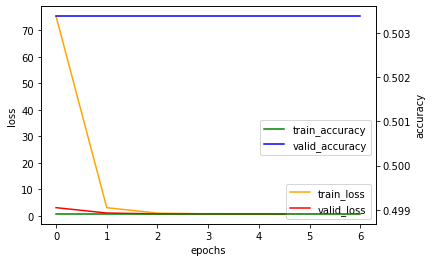

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()    #x를 공유

# loss 그래프
loss_ax.plot(hist.history['loss'], 'orange', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='valid_loss')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower right')

# accuracy 그래프
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='valid_accuracy')
acc_ax.set_xlabel('epochs')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5))

plt.show()